In [1]:
# import lsst.summit.extras

In [1]:
# lsst.summit.__file__

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MYpsfPlotting import makeAzElPlot, makeTableFromSourceCatalogs, makeFocalPlanePlot, makeEquatorialPlot
from atmospheric_dispersion_correction import addADC_to_Table
from lsst.obs.lsst import LsstComCam, LsstCam
import matplotlib.pyplot as plt
from ellipticity_util import addFieldCoords_to_Table, makeOCSPlot, read_batoid_table, addOpticalCoords_to_Table, MakeGridMedianPSF
from lsst.ts.aos.analysis import StateFetcher #source .user_setups
from lsst.daf.butler import Butler
import numpy as np

## set up

In [3]:
# #LSSTCam
# camera = LsstCam().getCamera()
# n_det = 189 # LSSTCam
#ComCam
camera = LsstComCam().getCamera()
n_det = 9 # ComCam

In [4]:
butler = Butler(
    "embargo", 
    collections=["LSSTComCam/nightlyValidation"], 
    instrument="LSSTComCam"
)
camera = LsstComCam().getCamera()

In [5]:
dayObs = 20241127
seqNum = 280
visit_id = int(f"{dayObs}{seqNum:05d}")

## Lettura icSrc

In [6]:
#puoi usarla su icSrc o su src
icSrcs={}
for i in range(n_det):
    icSrcs[i] = butler.get("icSrc", dataId={"visit":visit_id, "detector":i})
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":8})
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

In [7]:
# add atmospheric dispersion correction to the table
# table = addADC_to_Table( table, elevation_angle, filter, pressure=800, temperature=15 )
# TODO: check if the default values are sensible

band = butler.get("postISRCCD", dataId={"exposure":visit_id, "detector":8}).getFilter().bandLabel
elevation_angle = visitInfo.boresightAzAlt[1].asDegrees() # elevation angle in degrees
table = addADC_to_Table( table, elevation_angle, band ) # optional pressure and temperature arguments

In [8]:
table = addOpticalCoords_to_Table( table )
table = addFieldCoords_to_Table( table, camera )

In [9]:
table_grid = MakeGridMedianPSF(table, 12, 12, 3)

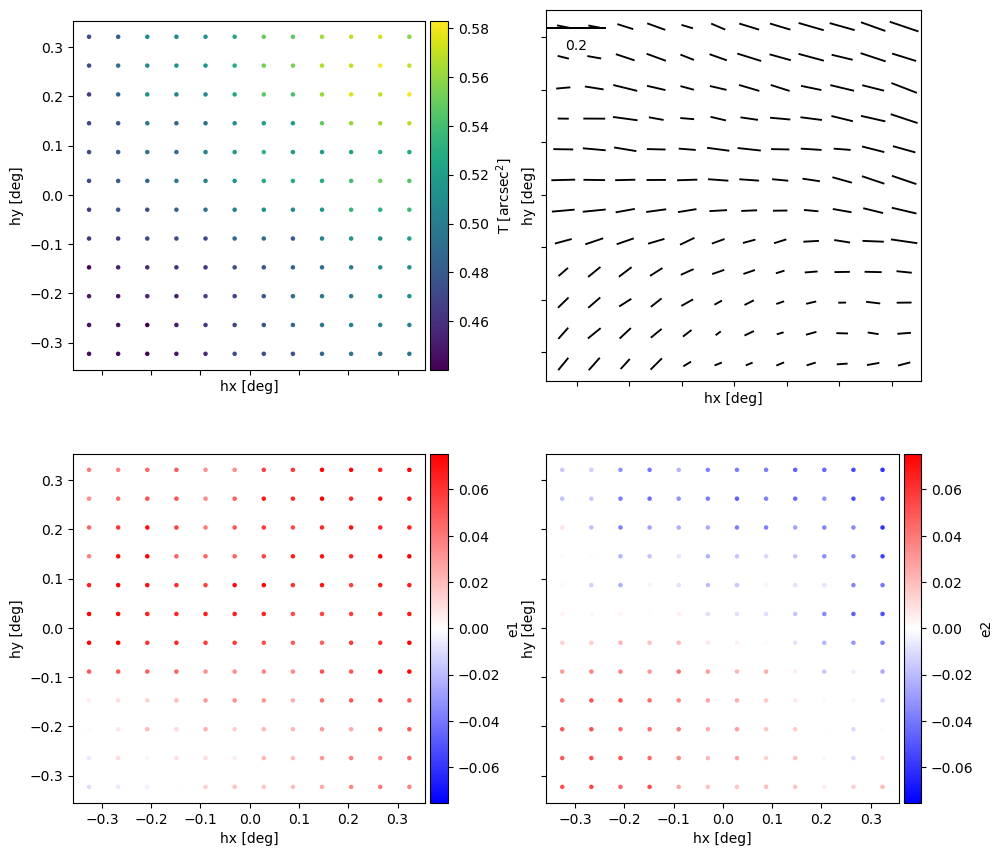

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeOCSPlot(fig, axes, table_grid, camera)
plt.show()

## alt/az in mm

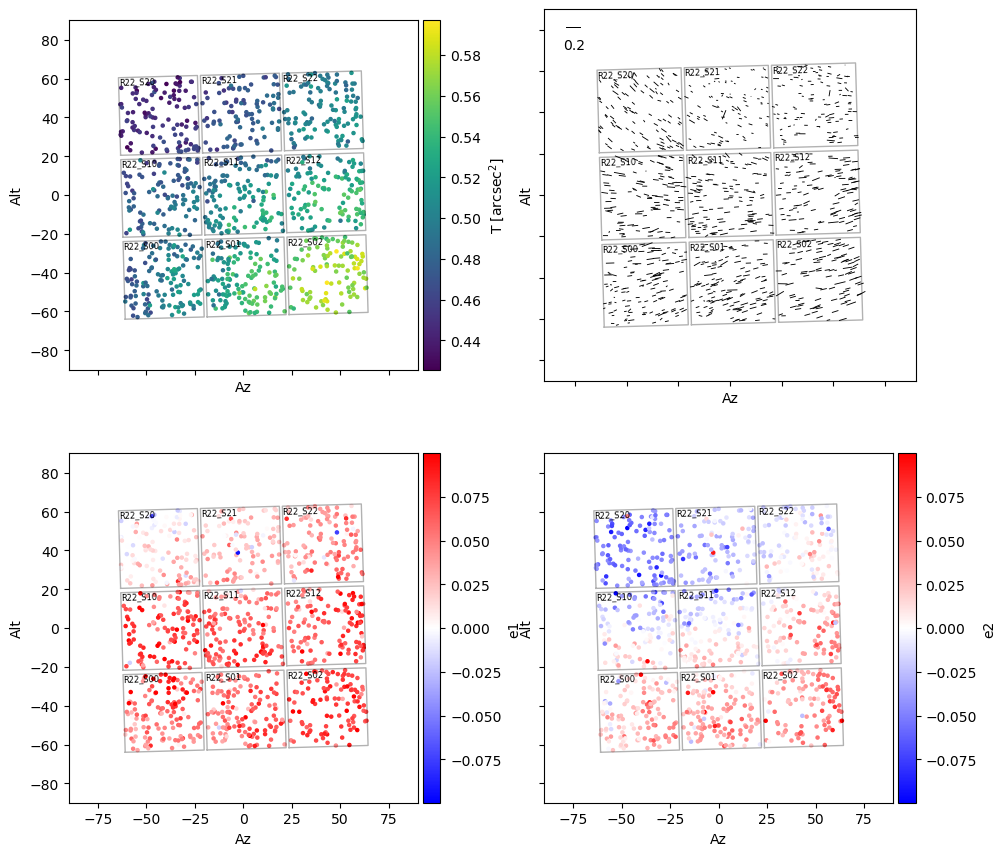

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeFocalPlanePlot(fig, axes, table, camera)
# plt.show()

In [22]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeEquatorialPlot(fig, axes, table, camera)
# plt.show()

# Convert mm to field angle and write output file

In [23]:
from ellipticity_util import addFieldCoords_to_Table, makeOCSPlot, read_batoid_table, addOpticalCoords_to_Table
import numpy as np

In [24]:
table = addOpticalCoords_to_Table( table )

In [25]:
table = addFieldCoords_to_Table( table, camera )

KeyError: 'oc_field_x'

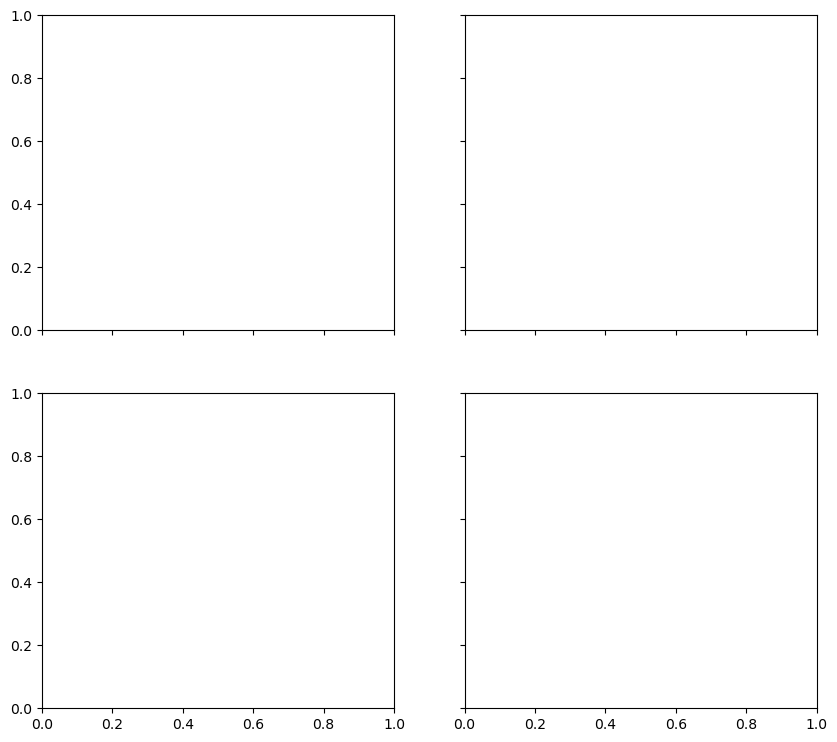

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeOCSPlot(fig, axes, table_grid, camera)
plt.show()

In [33]:
from astropy.io import ascii

In [34]:
outname = folder + 'rzs/ellip_maps/imsim_seq%.8d.csv'%seqnum
outname = folder + 'imsim_seq%.8d.csv'%seqnum
# outname = '/home/r/rzanmar/coords_seq%.8d.csv'%seqnum

In [35]:
outname

'/sdf/data/rubin/shared/image_quality/imsim/imsim_seq00000182.csv'

In [36]:
ascii.write(table[ 'oc_field_x','oc_field_y','oc_Ixx','oc_Iyy','oc_Ixy', ],outname, format='csv', fast_writer=False, overwrite=True)

In [45]:
table.meta['ocRot']

array([[ 0.50193363, -0.86490614],
       [-0.86490614, -0.50193363]])

# verify mm to field [deg] conversion

In [37]:
hx, hy = table['x'] * 0.2 / 36, table['y'] * 0.2 / 36      # 0.2 arcsec / pix * pix / 10um -> 0.2/36 deg/mm

In [38]:
hx_rot, hy_rot = table['oc_x'] * 0.2 / 36, table['oc_y'] * 0.2 / 36

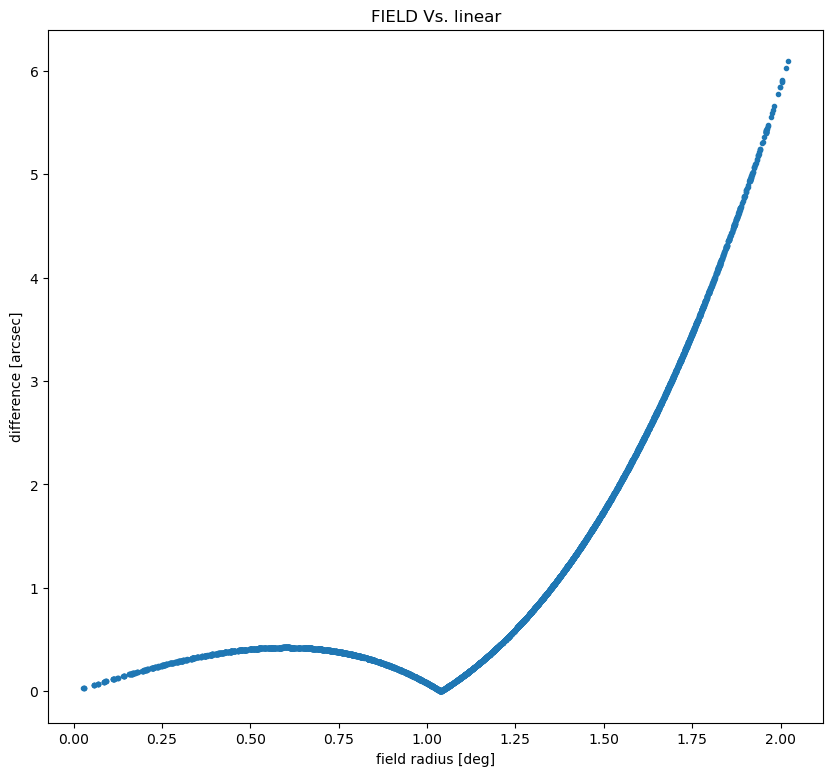

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 9), sharex=True, sharey=True)
plt.plot( np.sqrt( table['oc_field_x']**2+table['oc_field_y']**2), np.sqrt( (table['oc_field_x'] - hx_rot)**2 + (table['oc_field_y'] - hy_rot)**2)*3600, '.' )
axes.set_xlabel('field radius [deg]')
axes.set_ylabel('difference [arcsec]')
axes.set_title('FIELD Vs. linear')
plt.show()

In [40]:
table.meta['aaRot']

array([[ 0.50193363, -0.86490614],
       [ 0.86490614,  0.50193363]])

In [41]:
table.meta['ocRot']

array([[ 0.50193363, -0.86490614],
       [-0.86490614, -0.50193363]])